# Detect Deepfake Phishing Attacks

3/24/2025, Dave Sisk, https://github.com/davidcsisk, https://www.linkedin.com/in/davesisk-doctordatabase/

A number of AI-driven multi-model deepfake exploits have garnered much attention over the past year, including deepfaked audio/video phishing email of the company's CEO instructing employees to make a funds transfer, and even a CEO himself being deepfaked into transferring company funds to a fake corporate headquarters.  Let's examine how we can put together tools from the AI/ML/data science realm to detect this type of deepfake attack. 

By "multi-modal", I'm referring to attacks delivered as communications that might include text, audio, and video content. 

Based on results from a 2024 poll conducted by Deloitte, **24.9% of 2190 C-suite and executives say that their organization has experienced one or more deepfake attacks on financial and accounting targets**.

## Examples of real-world attacks from 2024 - present

Deepfaked CEO scam attempt: https://www.theguardian.com/technology/article/2024/may/10/ceo-wpp-deepfake-scam

Private video sharing phishing attack: https://incidentdatabase.ai/cite/965#r4845

Deepfaked Brad Pitt and the $850K romance scam:  https://incidentdatabase.ai/cite/901/

#### The proposed AI-driven Attack Detection Framework:
![CybersecurityAI-AnomalyDetection-Flowchart.jpg](.\CybersecurityAI-AnomalyDetection-Flowchart.jpg)

"Easy for you to draw"...right?  Let's demonstrate it.

In [13]:
#! pip install vosk
#! pip install spacy
# Install the spaCy model
#! python -m spacy download en_core_web_sm

## Fabricated Example Attacks For Analysis:
The fabricated artifacts below were designed to appear realistic and relevant to our organization.

**If an audio message with this very recognizable voice like the one below came in what appeared to be an official communication, how believable would it be?**

In [1]:
# Play the audio using the default OS audio player
wav_file = './deepfake_DonaldTrump-audio.wav'
!start {wav_file}

**If a video message from this very well-known public figure similar to the one below was sent to all employees from what appeared to be an official source, how believable would it be?**

In [2]:
# Play the video using the default OS video player
video_file = './deepfake_ElonMusk_SocialSecurityPhishing.mp4'
!start {video_file}

I used inexpensive and readily-available AI tech to create both of these deepfakes.  If these examples are not believable enough, consider that it's merely a matter of using slightly more expensive or involved AI tech to create even better deepfakes.  Overall, the obvious answer to the question at hand is this:  These are believable enough to potentially cause harm.

## Pre-req: Build Vectorized Library of known phishing attacks
In the proposed framework, this datastore of known attacks would be built over time by the reinforcement learning loop.  For this example, we'll build one using previously AI-generated phishing examples in a temporary datastore.

Note that I'm using a free/open-source HuggingFace text embedding LLM for this purpose. This model runs locally, and there are no external API calls...no data leaves the host or device this notebook is running on.

In [3]:
# Build the datastore of known phishing messages (30 samples)
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import warnings

# Suppress the FutureWarning from transformers
warnings.filterwarnings('ignore', category=FutureWarning, module='transformers.tokenization_utils_base')

# Load the CSV into a pandas dataframe
exploit_df = pd.read_csv('./deepfake_phishing_examples.csv')

# Ensure 'Subject' and 'Body' columns exist, create them if missing
if 'Subject' not in exploit_df.columns:
    exploit_df['Subject'] = ''
if 'Body' not in exploit_df.columns:
    exploit_df['Body'] = ''

# Initialize the sentence-transformers model
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Combine Subject and Body into a single column for embedding, handling empty values
exploit_df['Subject'] = exploit_df['Subject'].fillna('')
exploit_df['Body'] = exploit_df['Body'].fillna('')
exploit_df['combined_text'] = (exploit_df['Subject'] + ' ' + exploit_df['Body']).str.strip()

# Calculate embeddings for the combined text
exploit_df['embeddings'] = exploit_df['combined_text'].apply(lambda x: embedding_model.encode(x))

# Function to perform cosine similarity search
def search_similar(query, top_n=3):
    query_embedding = embedding_model.encode(query).reshape(1, -1)
    embeddings = np.vstack(exploit_df['embeddings'].values)
    similarities = cosine_similarity(query_embedding, embeddings).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]
    results = exploit_df.iloc[top_indices][['Subject', 'Body', 'combined_text']].copy()
    results['similarity_score'] = similarities[top_indices]
    results['preview'] = results['combined_text'].apply(lambda x: x[:100] if x else 'No content available')
    return results[['preview', 'similarity_score']]

exploit_df.shape

c:\Users\Dave Sisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


(34, 4)

In [7]:
# Take a look at a few rows
exploit_df.sample(3)

,Subject,Body,combined_text,embeddings
15,Vendor Payment Escalation,"Finance must issue $57,300 to [Fake Vendor] be...",Vendor Payment Escalation Finance must issue $...,"[-0.05856455, 0.057299707, -0.013049668, -0.03..."
0,Urgent Wire Transfer – Confidential,"Hi [Employee Name], I’m in a meeting right now...",Urgent Wire Transfer – Confidential Hi [Employ...,"[-0.11886531, 0.09246948, -0.006677438, 0.0089..."
21,Temporary Payment Authorization,"Finance is cleared to move $80,400 for M&A han...",Temporary Payment Authorization Finance is cle...,"[0.02071188, 0.040108047, -0.008084949, 0.0537..."


Note that the purpose of the vector embeddings is **to capture the *meaning* of the text in a numeric form that we can do *downstream analytics* with**.  These are the <u>**meaningful numbers**</u> you hear me talk about.

In [8]:
# Example query with a custom number of top matches
query = "urgent action required for account security"
top_n = 5  # Specify the number of top matches to return
results = search_similar(query, top_n=top_n)
print(results)

                                              preview  similarity_score
3   Urgent from Mobile I’m traveling and can’t acc...          0.497088
7   Immediate Compliance Wire I’ve been told we ha...          0.489520
22  Banking Delay Mitigation I’ve been notified th...          0.480011
13  Transfer Instruction: Urgent Initiate a transf...          0.461940
0   Urgent Wire Transfer – Confidential Hi [Employ...          0.421657


In practice, we would build this library over time via the reinforcement learning loop at the bottom right in the framework flowchart.  This means that we would start with little or no examples, and accumulate them as we proceeded, eventually amassing a large library of labeled data as examples. 

Also in practice, these vector search queries would be run against a vector database hydrated with the above-mentioned data instead of against a temporary in-memory dataframe.

## Pre-req:  Construct Knowledge Graph from Available Data

We'll build the core knowledge graph from known good data...for this example, we'll use the AI-generated corporate_communication_examples sample data.

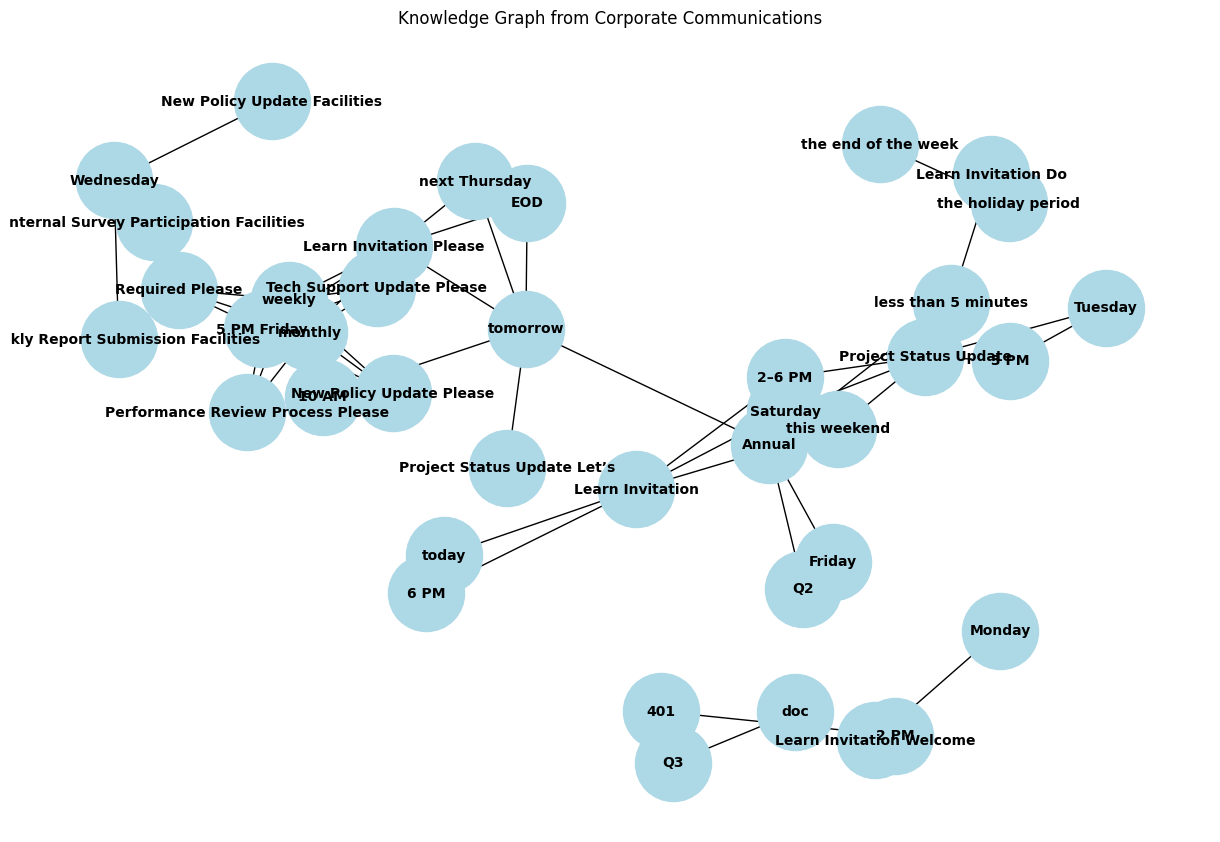

In [9]:
# Build core knowledge graph from known good data
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt

# Load the SpaCy model for NER
nlp = spacy.load("en_core_web_sm")

# Load the corporate communication examples CSV file
corporate_df = pd.read_csv('./corporate_communication_examples.csv')

# Initialize a graph
knowledge_graph = nx.Graph()

# Function to extract entities and relationships from text
def extract_entities_and_relationships(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    # Add edges between entities to represent relationships
    for i, entity1 in enumerate(entities):
        for entity2 in entities[i + 1:]:
            knowledge_graph.add_edge(entity1, entity2)

# Process each row in the dataframe
for _, row in corporate_df.iterrows():
    combined_text = f"{row['Subject']} {row['Body']}"
    extract_entities_and_relationships(combined_text)

# Visualize the knowledge graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(knowledge_graph, k=0.5)
nx.draw(knowledge_graph, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold")
plt.title("Knowledge Graph from Corporate Communications")
plt.show()

In [10]:
# Define the extract_entities helper function for subsequent KG use
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

We'll extend the knowledge graph with data for the known phishing attempts...this is the same data that we used to hydrate the vector datastore.

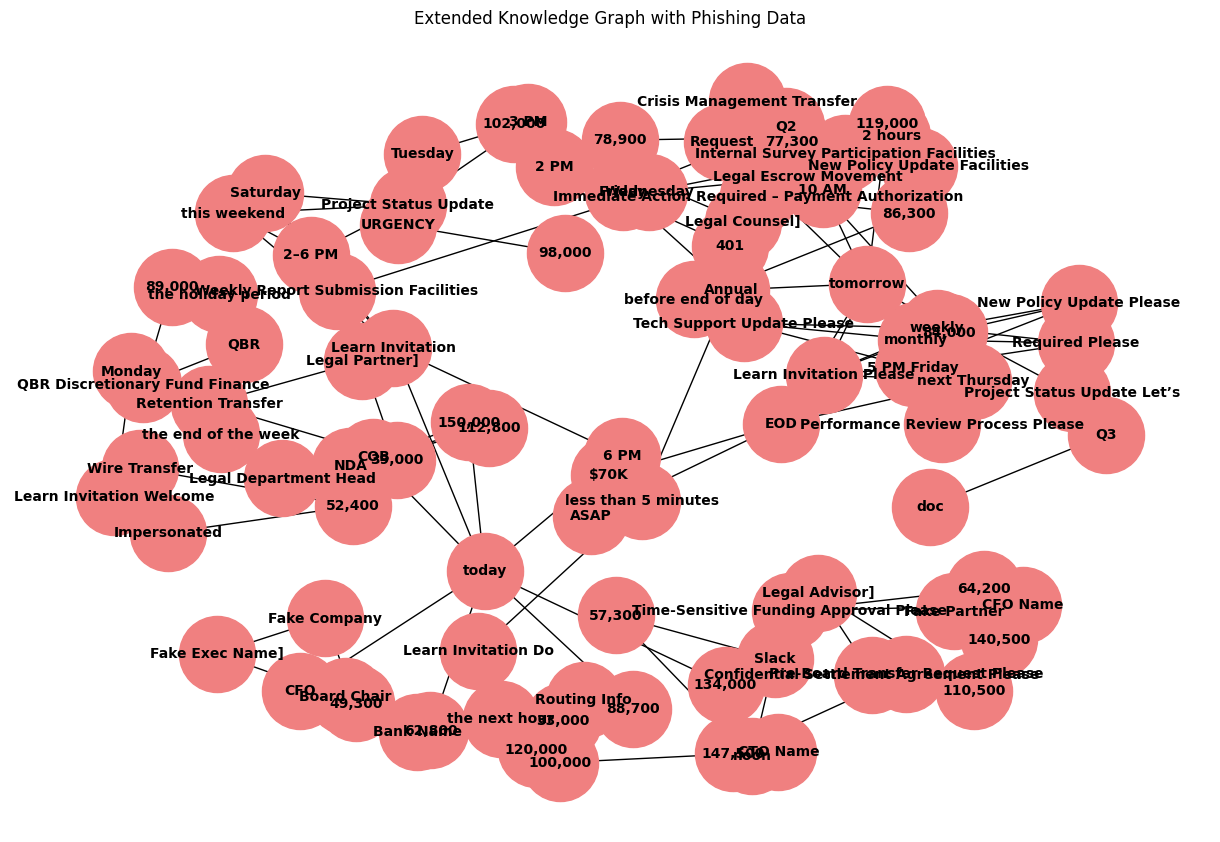

In [11]:
# Extend the knowledge graph with known phishing attempt data
def extend_knowledge_graph_with_phishing_data(df, graph):
    for _, row in df.iterrows():
        combined_text = row['combined_text']
        entities = extract_entities(combined_text)
        for i, entity1 in enumerate(entities):
            for entity2 in entities[i + 1:]:
                graph.add_edge(entity1, entity2)

# Extend the knowledge graph
extend_knowledge_graph_with_phishing_data(exploit_df, knowledge_graph)

# Visualize the extended knowledge graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(knowledge_graph, k=0.5)
nx.draw(knowledge_graph, pos, with_labels=True, node_size=3000, node_color="lightcoral", font_size=10, font_weight="bold")
plt.title("Extended Knowledge Graph with Phishing Data")
plt.show()

We've built the necessary data artifacts to leverage in this detection.  Now, let's proceed to feed some incoming data through the process.

## Incoming Data Enters the Framework...

### Pre-processing steps

Our first order of business is to get text transcriptions of the messages in these examples, so we can keep any vector search functionality in the text-only realm where we have known good models for that functionality. We'll leverage AI tooling to accomplish these transcriptions.

### Deepfake Audio Message
We can transcribe from the WAV audio file directly using the smallest open-source Vosk model that has an internalized language graph...this should produce a reasonably accurate transcription. (If the audio were in compressed MP3 file format [very likely if it came in an email, for instance], we'd have to convert it to WAV audio format first, then transcrible the text from that. That's merely a requirement of this particular model though, not the overall technology.)

We will use the Vosk models for transcription...these are small in size, free/open-source, and run locally, meaning no data leaves the current host in API calls.

In [14]:
# Let's start with the audio transcription
from vosk import Model, KaldiRecognizer
import wave
import json
import textwrap

# Load the 2nd smallest Vosk model
transcription_model = Model("./vosk-model-en-us-0.22-lgraph")

wav_file = './deepfake_DonaldTrump-audio.wav'

# Open the audio file
with wave.open(wav_file, "rb") as wf:
    if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getframerate() not in [8000, 16000]:
        raise ValueError("Audio file must be WAV format mono PCM.")
    
    recognizer = KaldiRecognizer(transcription_model, wf.getframerate())
    recognizer.SetWords(True)
    
    transcription = []
    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        if recognizer.AcceptWaveform(data):
            result = json.loads(recognizer.Result())
            transcription.append(result.get("text", ""))
    
    # Get the final transcription
    final_result = json.loads(recognizer.FinalResult())
    transcription.append(final_result.get("text", ""))

# Combine all parts of the transcription
transcribed_text_audio = " ".join(transcription)

# Wrap the text for better readability
wrapped_text_audio = textwrap.fill(transcribed_text_audio, width=60)
print("Transcribed Audio Text:\n", wrapped_text_audio)

Transcribed Audio Text:
 hi shane i'm following up on the audit readiness review
issue in q one expenses for contractor payments we need to
transfer one thirty seven thousand eight hundred twenty
dollar zero sense to the holding account a b c one twenty
three this must be sent by three pm today so do d o g e can
reflected in the pre-ordered submission let me know once the
transfer is done thanks


### Deepfake Video Message
Next, we'll transcribe text from the audio track on the video to get the exploit message.  This requires multiple steps to get the audio track from the video, then transcribe text from the audio. Extracting audio from the video is easy and deterministic...typical tooling can be used for that task.  AI tech is again needed to transcribe the audio to text...we'll use the same Vosk models for the text transcription. 

In [15]:
# Let's transcribe text from the video
import os
import wave
from vosk import Model, KaldiRecognizer
import json
import textwrap

# Load the Vosk model
model = Model("./vosk-model-en-us-0.22-lgraph")

# Path to the video file
video_file = './deepfake_ElonMusk_SocialSecurityPhishing.mp4'
audio_file = './extracted_audio.wav'

# Delete the extracted audio file if it already exists
if os.path.exists(audio_file):
    os.remove(audio_file)

# Extract audio using ffmpeg (suppress output)
!ffmpeg -i {video_file} -vn -acodec pcm_s16le -ar 16000 -ac 1 {audio_file} >nul 2>&1

# Transcribe the extracted audio
with wave.open(audio_file, "rb") as wf:
    if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getframerate() not in [8000, 16000]:
        raise ValueError("Audio file must be WAV format mono PCM.")
    
    recognizer = KaldiRecognizer(model, wf.getframerate())
    recognizer.SetWords(True)
    
    transcription = []
    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        if recognizer.AcceptWaveform(data):
            result = json.loads(recognizer.Result())
            transcription.append(result.get("text", ""))
    
    # Get the final transcription
    final_result = json.loads(recognizer.FinalResult())
    transcription.append(final_result.get("text", ""))

# Combine all parts of the transcription
transcribed_text_video = " ".join(transcription)

# Wrap the text for better readability
wrapped_text_video = textwrap.fill(transcribed_text_video, width=60)
print("\nTranscribed Video Text:\n", wrapped_text_video)


Transcribed Video Text:
 greetings valued employees immediate action is needed from
you please go to the listed u r l logging into your social
security account and change your password this will provide
a immediate flag that your social security account is valid
please complete this task task by five pm today thank you


## Take these examples combined with typical non-attack communications, and run them through the proposed framework.

I have some AI-generated examples of typical corporate communications...we'll combine those with the two deepfake transcripted messages, and feed this through the whole process outlined in the framework flowchart.

In [16]:
import pandas as pd

# Load the CSV file into a pandas dataframe
incoming_df = pd.read_csv('./corporate_communication_examples.csv')

# Add the transcribed audio and video text as new rows
incoming_df = pd.concat([
    incoming_df,
    pd.DataFrame({'Subject': [''], 'Body': [transcribed_text_audio]}),
    pd.DataFrame({'Subject': [''], 'Body': [transcribed_text_video]})
], ignore_index=True)


In [19]:

# Display the a few rows of the dataframe to verify the data
incoming_df.sample(3)

,Subject,Body
52,Office Maintenance Notice,Please use the updated template for all expens...
18,Holiday Schedule Announcement,We’re aligning our department goals with Q2 OK...
34,Client Follow-up Required,Attached is the latest draft of the policy doc...


In [20]:
# Display the last 3 rows to make sure we have the two phishing messages
incoming_df.tail(3)

,Subject,Body
99,Internal Survey Participation,Please confirm your attendance for next Thursd...
100,,hi shane i'm following up on the audit readine...
101,,greetings valued employees immediate action is...


Let's calculate their vector embeddings using the same embedding model as was used for the known exploits.

In [21]:
# Combine Subject and Body into a single column for embedding
incoming_df['combined_text'] = (incoming_df['Subject'] + ' ' + incoming_df['Body']).str.strip()

# Calculate embeddings for the combined text
incoming_df['embeddings'] = incoming_df['combined_text'].apply(lambda x: embedding_model.encode(x))

In [22]:
# Take a look at the data
incoming_df.tail(5)

,Subject,Body,combined_text,embeddings
97,Lunch and Learn Invitation,This is a friendly reminder to submit your tim...,Lunch and Learn Invitation This is a friendly ...,"[-0.040350206, 0.009667494, 0.07144351, 0.0270..."
98,Quarterly Goals Alignment,Let me know if there are any blockers on your ...,Quarterly Goals Alignment Let me know if there...,"[-0.073084936, -0.001465058, -0.05476325, -0.0..."
99,Internal Survey Participation,Please confirm your attendance for next Thursd...,Internal Survey Participation Please confirm y...,"[-0.027608344, -0.015846385, 0.069024816, -0.0..."
100,,hi shane i'm following up on the audit readine...,hi shane i'm following up on the audit readine...,"[-0.025454385, 0.024557797, -0.00035300324, -0..."
101,,greetings valued employees immediate action is...,greetings valued employees immediate action is...,"[-0.065204225, 0.06724257, -0.049596276, -0.06..."


We've done the "encoding" section of the flowchart, now let's do the "unsupervised ML" section of it. We'll run the vector embeddings of the combined_text through an anomaly detection algorithm. 

Note that the data for this step is time-bounded...we are using a sliding window time-slice.  In practice, we would take a larger time-slice of incoming data for this step, but here we'll use the 102 incoming messages, two of which we know to be phishing attempts.

In this step, we want to cast a fairly large net.

In [23]:
# Train an unsupervised anomaly detection model using Isolation Forest
from sklearn.ensemble import IsolationForest

# Extract embeddings from the dataframe
embeddings = np.vstack(incoming_df['embeddings'].values)

# Create the Isolation Forest model with automatic contamination
anomaly_detection_model = IsolationForest(n_estimators=100, contamination=0.1, random_state=96)

# Fit the model to the embeddings
anomaly_detection_model.fit(embeddings)

# Predict anomalies (-1 for anomaly, 1 for normal)
incoming_df['anomaly_flag'] = anomaly_detection_model.predict(embeddings)

# Convert anomaly_flag to a more readable format (e.g., 1 for anomaly, 0 for normal)
incoming_df['anomaly_flag'] = incoming_df['anomaly_flag'].apply(lambda x: 1 if x == -1 else 0)

In [24]:
incoming_df['anomaly_flag'].value_counts()

anomaly_flag
0    91
1    11
Name: count, dtype: int64

In [25]:
incoming_df[incoming_df['anomaly_flag'] == 1]

,Subject,Body,combined_text,embeddings,anomaly_flag
5,Quarterly Goals Alignment,IT will perform system maintenance this weeken...,Quarterly Goals Alignment IT will perform syst...,"[-0.06864202, 0.0023948208, -0.00785511, -0.07...",1
7,New Policy Update,Facilities will inspect all fire safety system...,New Policy Update Facilities will inspect all ...,"[0.014255533, -0.023002164, -0.009117434, -0.0...",1
20,Q2 Sales Review,Don’t forget to complete the internal engageme...,Q2 Sales Review Don’t forget to complete the i...,"[0.0040210653, 0.0086829625, 0.004856935, 0.03...",1
21,Annual Leave Request Process,Don’t forget to complete the internal engageme...,Annual Leave Request Process Don’t forget to c...,"[0.06320091, 0.024744986, 0.041019954, 0.05735...",1
26,Holiday Schedule Announcement,Facilities will inspect all fire safety system...,Holiday Schedule Announcement Facilities will ...,"[0.026803065, 0.023169715, 0.010500588, 0.0342...",1
34,Client Follow-up Required,Attached is the latest draft of the policy doc...,Client Follow-up Required Attached is the late...,"[-0.11022649, 0.031928483, -0.04852979, -0.038...",1
35,Client Follow-up Required,Let me know if there are any blockers on your ...,Client Follow-up Required Let me know if there...,"[-0.11045495, 0.0053985505, 0.0021303995, -0.0...",1
60,Tech Support Update,The marketing team has requested input on Q3 p...,Tech Support Update The marketing team has req...,"[-0.07493054, -0.04828136, 3.7405018e-05, -0.0...",1
96,Performance Review Process,IT will perform system maintenance this weeken...,Performance Review Process IT will perform sys...,"[-0.053396206, 0.033623185, -0.0168211, -0.021...",1
100,,hi shane i'm following up on the audit readine...,hi shane i'm following up on the audit readine...,"[-0.025454385, 0.024557797, -0.00035300324, -0...",1


We see our two phishing attempts flagged, along with other white noise creating false positives. Ideally, we want the anomaly detection to be loose enough to have **zero false negatives** at the expense of **more false positives**. We'll handle most of those false positives in the next steps.

In [26]:
# New dataframe with just the possible anomalies for convenience
possible_anomalies_df = incoming_df[incoming_df['anomaly_flag'] == 1].copy()

Perform a vector search using the vector embeddings against our datastore of known phishing attempts to get a similarity score...add that similarity score as a new column in the dataframe.  Note the number of matches with a similarity score greater than 0.3 (this threshold would be a tuning parameter in the process).

In [27]:
# Perform vector search for each row in possible_anomalies_df
possible_anomalies_df['similarity_score'] = possible_anomalies_df['combined_text'].apply(
    lambda text: search_similar(text, top_n=1)['similarity_score'].iloc[0]
)

len(possible_anomalies_df[possible_anomalies_df['similarity_score'] > 0.3])

4

In [28]:
# Filter rows with similarity_score greater than 0.3
anomaly_matched_df = possible_anomalies_df[possible_anomalies_df['similarity_score'] > 0.3]

# Display the filtered rows
anomaly_matched_df

,Subject,Body,combined_text,embeddings,anomaly_flag,similarity_score
34,Client Follow-up Required,Attached is the latest draft of the policy doc...,Client Follow-up Required Attached is the late...,"[-0.11022649, 0.031928483, -0.04852979, -0.038...",1,0.389887
35,Client Follow-up Required,Let me know if there are any blockers on your ...,Client Follow-up Required Let me know if there...,"[-0.11045495, 0.0053985505, 0.0021303995, -0.0...",1,0.459223
100,,hi shane i'm following up on the audit readine...,hi shane i'm following up on the audit readine...,"[-0.025454385, 0.024557797, -0.00035300324, -0...",1,0.523283
101,,greetings valued employees immediate action is...,greetings valued employees immediate action is...,"[-0.065204225, 0.06724257, -0.049596276, -0.06...",1,0.378240


We see our two known phishing attempts (true positives), and two other matches above the threshold (false positives). Leveraging vector search improved the accuracy, precision, and recall, but is still not perfect.

Next, let's apply a knowledge graph to achieve named entity recognition, and see if that improves our results by eliminating more of the false positives.

Let's now update the knowledge graph with data from this incoming_df.

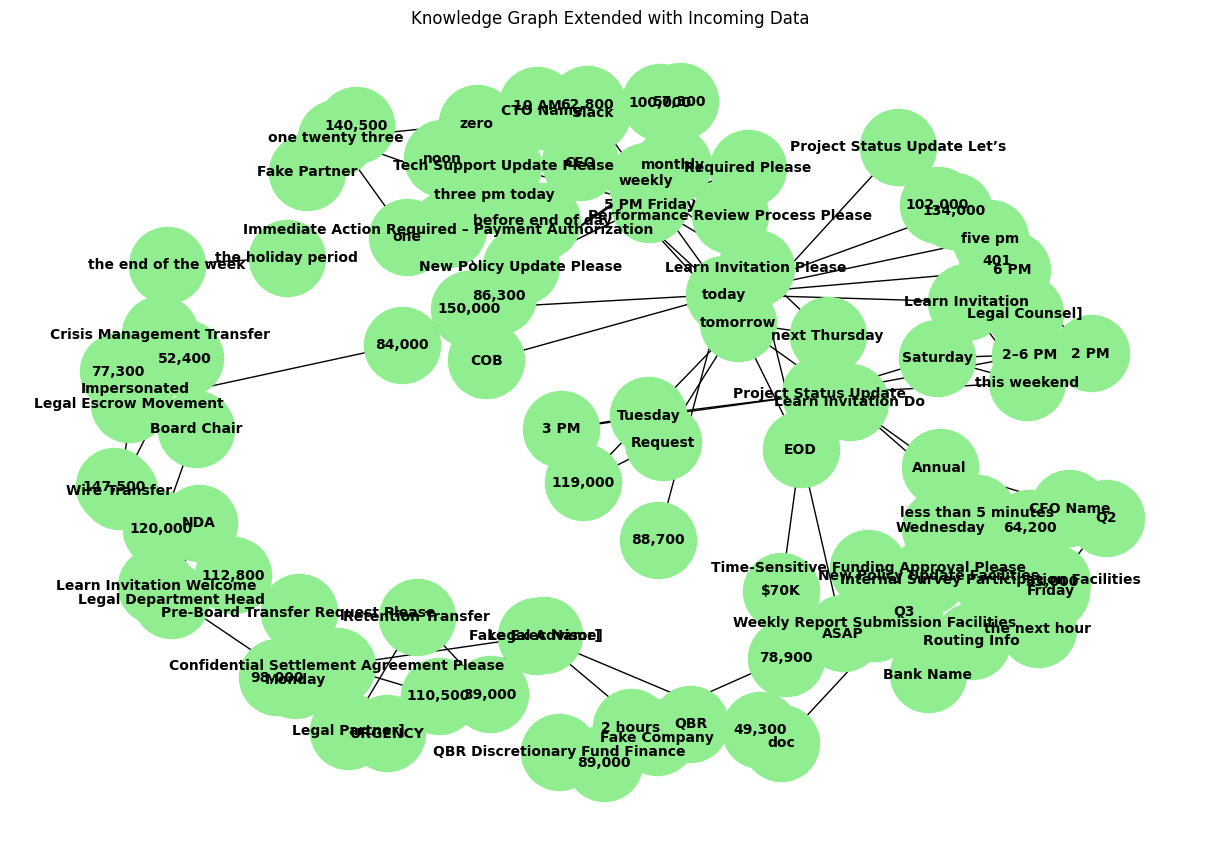

In [29]:
# Update the knowledge graph with data from incoming_df
extend_knowledge_graph_with_phishing_data(incoming_df, knowledge_graph)

# Visualize the updated knowledge graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(knowledge_graph, k=0.5)
nx.draw(knowledge_graph, pos, with_labels=True, node_size=3000, node_color="lightgreen", font_size=10, font_weight="bold")
plt.title("Knowledge Graph Extended with Incoming Data")
plt.show()

In [30]:
# Function to validate entities against the extended knowledge graph
def validate_with_extended_knowledge_graph(text, graph):
    entities = extract_entities(text)
    for i, entity1 in enumerate(entities):
        for entity2 in entities[i + 1:]:
            if graph.has_edge(entity1, entity2):
                return True  # Valid relationship found
    return False  # No valid relationships found

# Apply validation to the rows in anomaly_matched_df
anomaly_matched_df = anomaly_matched_df.copy()  # Avoid SettingWithCopyWarning
anomaly_matched_df.loc[:, 'is_valid'] = anomaly_matched_df['combined_text'].apply(
    lambda text: validate_with_extended_knowledge_graph(text, knowledge_graph)
)

# Filter rows where is_valid is True
filtered_anomalies = anomaly_matched_df[anomaly_matched_df['is_valid']]

# Display the filtered anomalies
filtered_anomalies

,Subject,Body,combined_text,embeddings,anomaly_flag,similarity_score,is_valid
100,,hi shane i'm following up on the audit readine...,hi shane i'm following up on the audit readine...,"[-0.025454385, 0.024557797, -0.00035300324, -0...",1,0.523283,True
101,,greetings valued employees immediate action is...,greetings valued employees immediate action is...,"[-0.065204225, 0.06724257, -0.049596276, -0.06...",1,0.378240,True


Voila!  In this particular case, applying the knowledge graph to the incoming data provided enough enough intelligence to ignore the remaining 2 false positives.  This worked in this particular case because the phishing attempts had enough relationships in common with the known good and known bad data in the knowledge graph. This approach won't always yield 100% correct results, but it will get us closer to the correct answers. 